## Convolutional Neural Networks and Computer Vision with PyTorch

In [118]:
import os
import pathlib
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
import random
from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
torch.__version__

'2.1.0+cpu'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Data preparation

In [48]:
# Create function
def walk_through_directory(dir_path):
    for dir_path, dir_name, file_name in os.walk(dir_path):
        print(f"There are {len(dir_name)} directories and {len(file_name)} images in '{dir_path}'.")
        
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx

def plot_transformed_image(image_path, transform, n = 3, seed = 42):
    random.seed(seed)
    random_image_path = random.sample(image_path, k = n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
            
def display_random_image(dataset: torch.utils.data.dataset.Dataset, classes: List[str] = None,
    n: int = 10, display_shape: bool = True, seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k = n)

    plt.figure(figsize = (16, 8))

    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        target_image_adjust = target_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        
        if classes:
            title = f"class: {classes[target_label]}"
            
            if display_shape:
                title = title + f"\nshape: {target_image_adjust.shape}"
                
        plt.title(title)

In [74]:
# Create class
class ImageFolderCustom(Dataset):
    def __init__(self, target_path: str, transform = None) -> None:
        self.path = list(pathlib.Path(target_path).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_path)
        
    def load_image(self, index: int) -> Image.Image:
        image_path = self.path[index]

        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.path)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [75]:
# Initialize data, image, train and test path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_path, test_path = image_path / "train", image_path / "test"

train_path, test_path

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [76]:
walk_through_directory(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


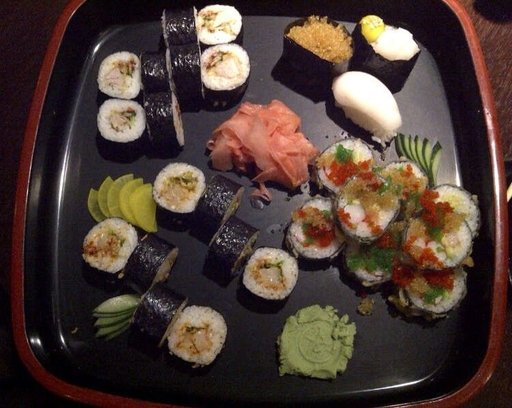

In [77]:
# View random image
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

image = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")

image

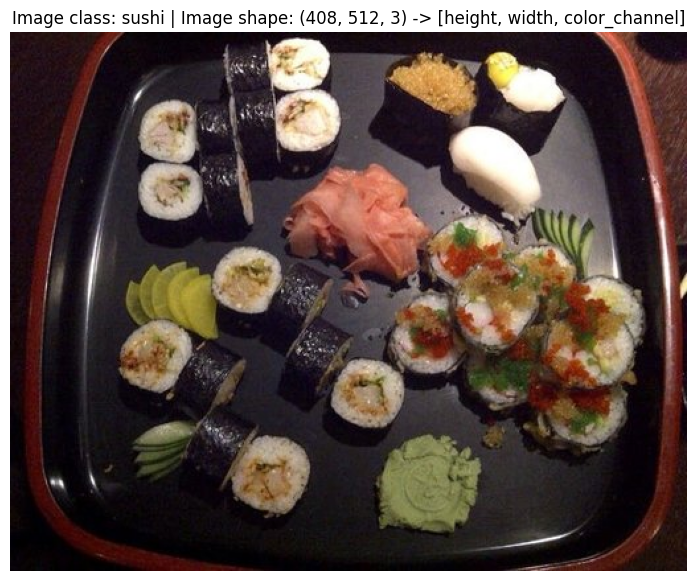

In [78]:
# View random image
image_as_array = np.asarray(image)

plt.figure(figsize = (10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channel]")
plt.axis(False);

#### 1.1 Transforming image data
Utilize `torchvision.transforms` for image transformation

In [79]:
# Transformation function
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

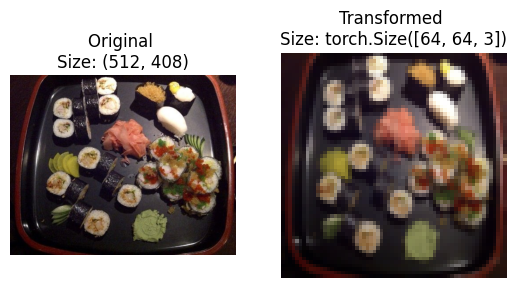

In [80]:
# Plotting random image and view after transformation
random.seed(42)

random_image_path = random.sample(image_path_list, k = 1)
random_image = random_image_path[0]

with Image.open(random_image) as f:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    # Change shape of image from C, H, W to H, W, C to suit matplotlib 
    transformed_image = data_transform(f).permute(1, 2, 0) 
    
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

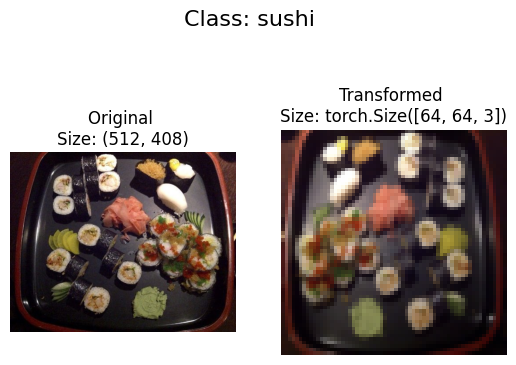

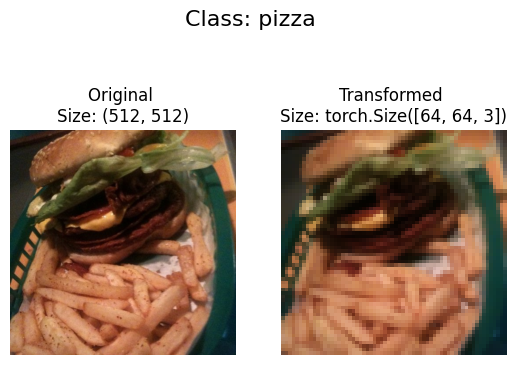

In [81]:
# Use function to plotting
plot_transformed_image(image_path_list, transform = data_transform, n = 2)

#### 1.2 ImageFolder to load image data

Utilize `torchvision.datasets.ImageFolder` to load image data

In [82]:
train_data = datasets.ImageFolder(root = train_path,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_path, 
                                 transform = data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [83]:
# View class
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [84]:
# View class in dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [85]:
# How many sample of train and test
len(train_data), len(test_data)

(225, 75)

In [86]:
# View first traind data
image, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channel, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channel]


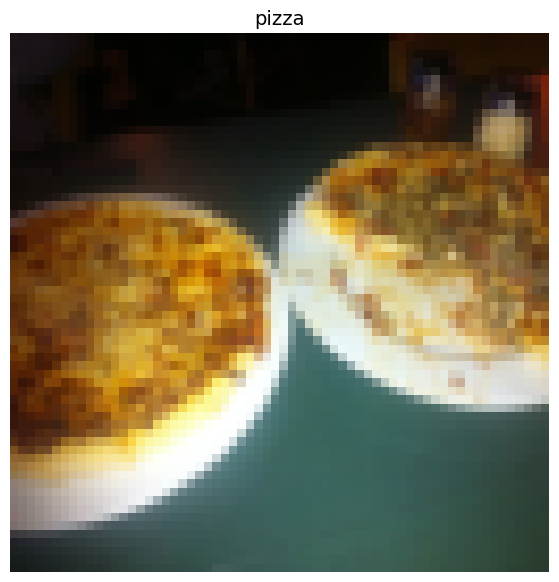

In [87]:
# View first image of train data
image_permute = image.permute(1, 2, 0)

print(f"Original shape: {image.shape} -> [color_channel, height, width]")
print(f"Image permute shape: {image_permute.shape} -> [height, width, color_channel]")

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(class_name[label], fontsize = 14);

In [88]:
# Turn train and test dataset into DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 5,
    num_workers = 1, shuffle = True)

test_dataloader = DataLoader(dataset = test_data, batch_size = 5, 
    num_workers = 1, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x21e0e48e160>,
 <torch.utils.data.dataloader.DataLoader at 0x21e0e6e9e20>)

In [89]:
image, label = next(iter(train_dataloader))

print(f"Image shape: {image.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([5, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([5])


#### 1.3 Loading image data with custom function

In [90]:
custom_train_data = ImageFolderCustom(target_path = train_path, transform = train_transform)
custom_test_data = ImageFolderCustom(target_path = test_path, transform = test_transform)

custom_train_data, custom_test_data

(<__main__.ImageFolderCustom at 0x21e0e48e9a0>,
 <__main__.ImageFolderCustom at 0x21e0e48ea90>)

In [91]:
len(custom_train_data), len(custom_test_data)

(225, 75)

In [92]:
custom_train_data.classes

['pizza', 'steak', 'sushi']

In [93]:
custom_train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [94]:
# Check equality of custom Dataset and ImageFolder Dataset
print((len(custom_train_data) == len(train_data)) & (len(custom_test_data) == len(test_data)))
print(custom_train_data.classes == train_data.classes)
print(custom_train_data.class_to_idx == train_data.class_to_idx)

True
True
True


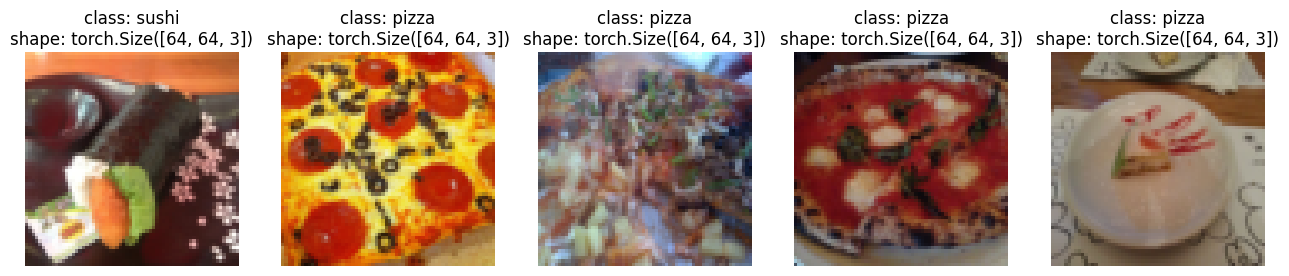

In [95]:
display_random_image(train_data, n = 5, classes = class_name, seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


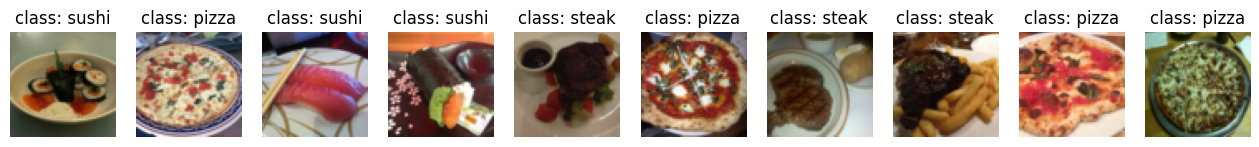

In [96]:
display_random_image(custom_train_data, n = 12, classes = class_name, seed = None)

In [97]:
# Turn custom loaded image into DataLoader
custom_train_dataloader = DataLoader(dataset = custom_train_data, batch_size = 1,
    num_workers = 0, shuffle = True)

custom_test_dataloader = DataLoader(dataset = custom_test_data, batch_size = 1, 
    num_workers = 0, shuffle = False)

custom_train_dataloader, custom_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x21e0dca5400>,
 <torch.utils.data.dataloader.DataLoader at 0x21e0e1b59a0>)

In [98]:
custom_image, custom_label = next(iter(custom_train_dataloader))

print(f"Image shape: {custom_image.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {custom_label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


In [99]:
# Incorporate transforms.TrivialAugmentWide()
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

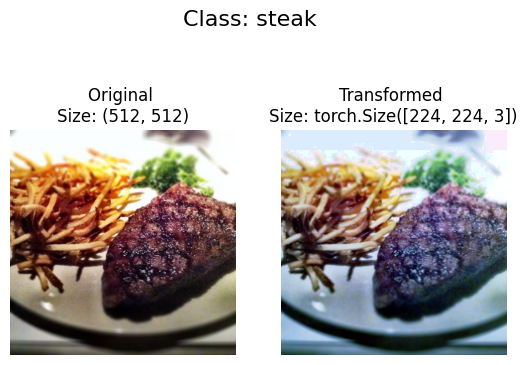

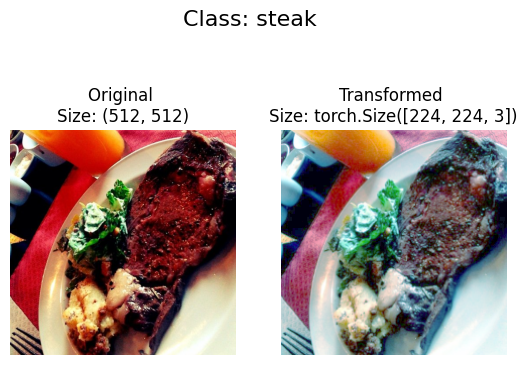

In [101]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_image(image_path = image_path_list,
    transform = train_transform, n = 2, seed = None
)

### 2. Model building

In [136]:
# TinyVGG model creation
class TinyVGG(nn.Module):
     def __init__(self, input_shape: int, hidden_unit: int, output_shape: int) -> None:
        super().__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_unit, 
                      kernel_size = 3, stride = 1, padding = 1),
             nn.ReLU(),
             nn.Conv2d(in_channels = hidden_unit, out_channels = hidden_unit,
                      kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_unit * 16 * 16, out_features = output_shape)
        )
            
        def forward(self, x: torch.Tensor):
            x = self.cnn_block_1(x)
            x = self.cnn_block_2(x)
            x = self.classifier(x)
            return x

#### 1. First model without data augmentation

In [137]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [138]:
simple_train_data = datasets.ImageFolder(root = train_path, transform = simple_transform)
simple_test_data = datasets.ImageFolder(root = test_path, transform = simple_transform)

In [139]:
batch_size = 32
worker_number = os.cpu_count()

print(f"Creating DataLoader's with batch size {batch_size} and {worker_number} worker.")

simple_train_dataloader = DataLoader(simple_train_data, batch_size = batch_size, 
    shuffle = True, num_workers = worker_number)
simple_test_dataloader = DataLoader(simple_test_data, batch_size = batch_size, 
    shuffle = False, num_workers = worker_number)

simple_train_dataloader, simple_test_dataloader

Creating DataLoader's with batch size 32 and 8 worker.


(<torch.utils.data.dataloader.DataLoader at 0x21e0df509d0>,
 <torch.utils.data.dataloader.DataLoader at 0x21e0df501c0>)

In [140]:
torch.manual_seed(42)

first_model = TinyVGG(input_shape = 3, hidden_unit = 10, 
                  output_shape = len(train_data.classes)).to(device)
first_model

TinyVGG(
  (cnn_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [141]:
summary(first_model, input_size = [1, 3, 64, 64]) 

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []